In [158]:
# Classic imports
import random
import os

# Chaning path is sometimes neccessary at first iteration because active directory can differ
# If you have diffrent directories or dataset in diffrent place - comment these two lines
# print(os.path.abspath(os.curdir))
# os.chdir("..")

from additonal_files.data_processing import csv_data_processing
from additonal_files.standard_scaler import standard_scaler
from additonal_files.pca import PCA
from pandas.plotting import scatter_matrix
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [232]:
# NOTE: Currently number of plots is calculated through rounding n_iter/n_plots to get plot interval
# It can generate error if the number exceed 10
# It also can plot n_plots - 1 due to rounding (I will refine it in next update)

# Parameters for algorithm
n_iter = 15             # iterations for algorithm to stop (additional stop variable)
k = 3                   # cluster number
standard = True         # standard scaling of data
PCA_chosen = True       # not/using PCA for reducing dismensionality
n_plots = 7             # number of plots for clusters
pass_plot = False       # if True or n_plots>9 - forcing not to plot cluster progress    

In [ ]:
# # This part of code is connected with local SQL Server Database (data processed with SQL and loaded back to Python with pyodbc in connection with SQL Server)
# # print(pyodbc.drivers())

# SERVER = r'JACOBE_DESKTOP\EXPERIMENT_DATA'
# DATABASE = 'clustering'
# UID = ''
# PASS = ''
# data_query = 'SELECT * FROM clustering'
# features_query = 'SELECT * FROM INFORMATION_SCHEMA.COLUMNS'

# # Using Windows Auth - if you want to use UID and PWD change connectionString and proper settings in database
# connectionString = f'DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={SERVER};DATABASE={DATABASE};TRUSTED_CONNECTION=YES'

# connection = pyd.connect(connectionString)
# cursor = connection.cursor()

# cursor.execute(features_query)
# data=cursor.fetchall()

# database = pd.read_sql(data_query, connection)

# connection.close()

# print(database)

In [233]:
# Data Processing with dedicated class (simple load with changing text/nonnumerical values to classes)
cdp = csv_data_processing()
database = cdp.process_data('dataset\\clustering\\clustering.txt')

# This is a place for processing database (multiple features allowed)
database_drop = database.drop(columns='Loan_ID').astype(float)
database = database[['ApplicantIncome', 'LoanAmount', 'Loan_Amount_Term']].copy()

# Deleting and storing the features names
if os.path.isdir(os.path.join(os.getcwd(), Path('exp_data'))) is False: os.mkdir('exp_data')
features = database.columns

# Saving them to txt and removing columns headers (for simpler indexing and cleaner code)
with open('exp_data/features.txt', 'w') as f:
    for index, feats in enumerate(features): f.write(str(index) + ": " + str(feats) + "\n")

database = database.set_axis(list(range(0,len(features),1)), axis='columns')

print("Processed database:")
print(database)


Processed database:
        0      1      2
0    4583  128.0  360.0
1    3000   66.0  360.0
2    2583  120.0  360.0
3    6000  141.0  360.0
4    2333   95.0  360.0
..    ...    ...    ...
376  5703  128.0  360.0
377  3232  108.0  360.0
378  2900   71.0  360.0
379  4106   40.0  180.0
380  4583  133.0  360.0

[381 rows x 3 columns]


0: ApplicantIncome
1: LoanAmount
2: Loan_Amount_Term



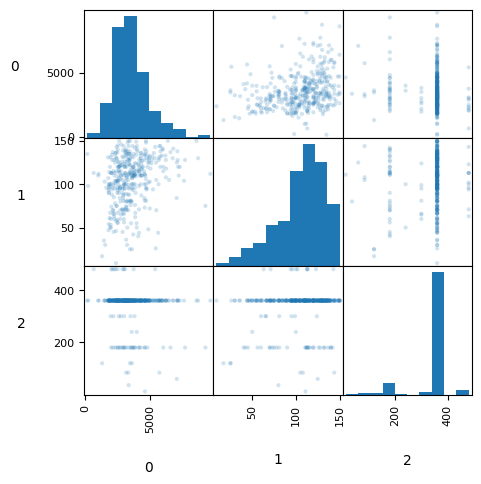

In [234]:
# Desciribing features with scatter matrix
with open('exp_data/features.txt', 'r') as f:
    print(f.read())

fig_scatter = scatter_matrix(database, alpha=0.2, figsize=(5,5), diagonal='hist')
for ax in fig_scatter.ravel():
    ax.set_xlabel(ax.get_xlabel(), labelpad=20)
    ax.set_ylabel(ax.get_ylabel(), rotation=0, ha='right', labelpad=20)

In [235]:
# Standard scaling of data
if standard is True:
    scaler = standard_scaler()
    database = scaler.scale(database)

    print(database)

            0         1         2
0    0.707469  0.812575  0.279522
1   -0.408932 -1.376596  0.279522
2   -0.703019  0.530102  0.279522
3    1.706799  1.271595  0.279522
4   -0.879330 -0.352629  0.279522
..        ...       ...       ...
376  1.497342  0.812575  0.279522
377 -0.245316  0.106391  0.279522
378 -0.479457 -1.200050  0.279522
379  0.371067 -2.294635 -2.349882
380  0.707469  0.989121  0.279522

[381 rows x 3 columns]


In [236]:
# Getting rid of null value records
nan_idx=[]
for iter, row in enumerate(database.values):
    for val in row:
        if pd.isnull(val) is True:
            nan_idx.append(iter)

database = database.drop(index=nan_idx, axis=1)
database = database.reset_index(drop=True)
print(database)

            0         1         2
0    0.707469  0.812575  0.279522
1   -0.408932 -1.376596  0.279522
2   -0.703019  0.530102  0.279522
3    1.706799  1.271595  0.279522
4   -0.879330 -0.352629  0.279522
..        ...       ...       ...
365  1.497342  0.812575  0.279522
366 -0.245316  0.106391  0.279522
367 -0.479457 -1.200050  0.279522
368  0.371067 -2.294635 -2.349882
369  0.707469  0.989121  0.279522

[370 rows x 3 columns]


2


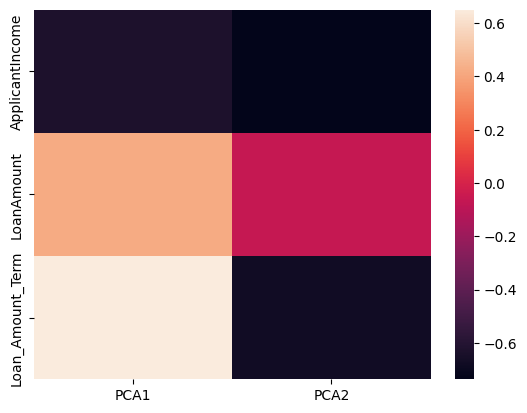

In [237]:
# PCA transform if chosen
if PCA_chosen is True:
    pca_transform = PCA()
    database = pca_transform.transform(database, features)

# Plotting data explainibility through PCA

In [238]:
# Picking random points for start of clustering
centroids = []
inertia_iter = []
for centers in range (0, k): centroids.append(database.loc[random.randint(0, database.shape[0])])

print(centroids)

[0    1.247256
1    0.269434
Name: 335, dtype: float64, 0    0.344407
1   -0.293108
Name: 194, dtype: float64, 0    0.849448
1    0.295753
Name: 237, dtype: float64]


In [239]:
# Problem was with the idx of DataFrame - they wasn't updated and deleted - and algorithm got wrong coordinates

# Init for iteration control
plot_interval = np.round(n_iter/n_plots)
iteration = 1
iter_stack = []

centroids_arch = []
clusters_arch = []

# Calculating distance from centroids and saving it to Dataframe
for iter in range(0, n_iter):
    distance = []
    for centers in centroids:
        sum = 0
        for idx, cordinate in enumerate(centers): sum += (database[idx] - cordinate)**2
        distance.append(np.sqrt(sum))

    distance = pd.DataFrame(np.transpose(distance))

    # Clustering data - changing labels through comparison of distance and searching for minimum
    labels = []
    for row in distance.iloc:
        labels.append(row[row==np.min(row)].index.values[0])
        
    distance['labels'] = labels
    del(labels)

    # Appending proper elements to proper clusters from chosen distances
    clusters=[]
    for label in range(0, k):
        clusters.append(database[distance["labels"]==label])

    # If data (features) are 2 dimensional - plot changes of clusters on plots
    if iteration == plot_interval:
        centroids_arch.append(centroids)
        clusters_arch.append(clusters)
        iter_stack.append(iter)

    # Updating coordinates for centeres of clusters
    centroids=[]
    for center in range(0, k): centroids.append(np.mean(database[distance['labels']==center], axis=0))

    # Calculating inertia for analysis (and for checking if it is working)
    inertia = 0
    for label in range(0, k):
        inertia += np.sum(distance[distance['labels']==label][label])
    inertia_iter.append(inertia)

    iteration += 1
    if iteration == plot_interval + 1: iteration = 1

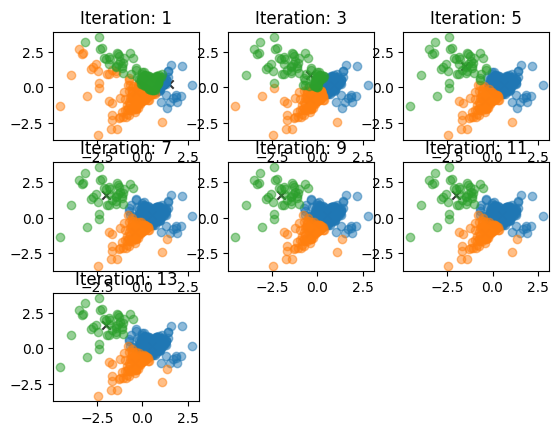

In [240]:
i = 1
fig_cluster = plt.figure()

# Defining number of plots and subplot scheme
if n_plots <= 3:
    d = 1
elif n_plots <= 6:
    d = 2
elif n_plots <= 9:
    d = 3
else:
    pass_plot = True

if pass_plot == False:
    for centroids, clusters in zip(centroids_arch, clusters_arch):
        if database.shape[1] == 2:
            ax_cluster = fig_cluster.add_subplot(3, d, i)
            for centers in centroids: ax_cluster.scatter(centers[0], centers[1], marker='x', c='black', alpha=0.8)
            for group in clusters: ax_cluster.scatter(group[0], group[1], marker='o', alpha=0.5)
            ax_cluster.title.set_text("Iteration: " + str(iter_stack[i-1]))

        # If data (features) are 3 dimensional - plot changes of clusters on 3D plot
        if database.shape[1] == 3:
            ax_cluster = fig_cluster.add_subplot(3, d, i, projection='3d')
            for centers in centroids: ax_cluster.scatter(centers[0], centers[1], centers[2], marker='x', c='black', alpha=0.8)
            for group in clusters: ax_cluster.scatter(group[0], group[1], group[2], marker='o', alpha=0.5)
            ax_cluster.title.set_text("Iteration: " + str(iter_stack[i-1]))

        i += 1
else:
    pass

# Plotting clusters state for next iterations

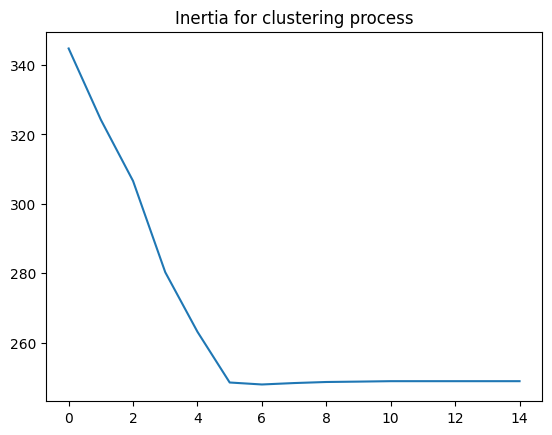

In [241]:
fig_inertia=plt.figure()
ax_inertia=fig_inertia.add_subplot()
ax_inertia.title.set_text("Inertia for clustering process")
ax_inertia.plot(inertia_iter)